In [1]:
# This notebook is used to
# 1. Refine the classifiers to mitigate data imbalance
# 2. Create ensemble classifier
# 3. Perform feature ablation

import os
import pickle5
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import copy
from random import sample
from joblib import dump, load
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, fbeta_score, make_scorer, accuracy_score, confusion_matrix, plot_confusion_matrix, roc_auc_score, brier_score_loss
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve, validation_curve
from sklearn.utils.class_weight import compute_class_weight

plt.style.use('bmh')
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.right" : False,
    "legend.frameon" : False,
    "figure.figsize" : (8, 5),
    "figure.dpi" : 300,
})

# suppress sklearn deprecated warnings
import warnings
def warn(*args, **kwargs): pass
warnings.warn = warn

### Read Data

In [2]:
suffix_old = ""
suffix = ""

n_features = 18
path_thyroid = "data/thyroid/"
path_without_thyroid = "data/no_thyroid/"
path = path_without_thyroid if n_features == 18 else path_thyroid
path_models = f"models/{n_features}features/"
path_images = f"figures/{n_features}features/"


In [3]:
# Read data
df_train = pd.read_csv(f"{path}train{suffix}.csv", index_col=0)
df_valid = pd.read_csv(f"{path}valid{suffix_old}.csv", index_col=0)
df_test = pd.read_csv(f"{path}test{suffix_old}.csv", index_col=0)

if n_features == 7:
    top_variables = [
        "Hyperlipemia\nHistoty of hyperlipemia",
        "FE",
        "Previous CABG",
        "Diabetes\nHistory of diabetes",
        "Previous Myocardial Infarction",
        "Smoke\nHistory of smoke",
        "Documented resting \nor exertional ischemia",
        "Survive7Y"
    ]
    df_train = df_train.loc[:, top_variables]
    df_valid = df_valid.loc[:, top_variables]
    df_test = df_test.loc[:, top_variables]

train, valid, test = df_train.to_numpy(), df_valid.to_numpy(), df_test.to_numpy()
X_train, y_train = train[:, :-1], train[:, -1]
X_valid, y_valid = valid[:, :-1], valid[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
feat_names = list(df_train.columns)

from collections import Counter
print(Counter(y_train))
print(Counter(y_valid))
print(Counter(y_test))

# All the numerical features that can be standarditazed
from utils import get_preprocess_std_num
preprocess_std = get_preprocess_std_num(feat_names)
preprocess_std_all = StandardScaler()

# Preprocessed ready-to-use train and valid set
process_tmp = preprocess_std.fit(X_train)
X_train_std = process_tmp.transform(X_train)
X_valid_std = process_tmp.transform(X_valid)

Counter({1.0: 3494, 0.0: 505})
Counter({1.0: 1165, 0.0: 169})
Counter({1.0: 1165, 0.0: 169})


### Ensemble
Combining the previous best models

In [4]:
from ensemble import build_ensemble, evaluate_ensemble, predict_ensemble

"""models = [
    "logreg_random_svmsmote_logreg",
    # "svc2_random_svmsmote_svc2",
    # "knn_random_svmsmote_knn",
    "rf1_random_bordersmote_rf1",
    "adaboost2_random_svmsmote_adaboost2",
    # "nn_random_svmsmote_nn",
    # "gb_random_svmsmote_gb",
    # "xgb_random_svmsmote_xgb",
]"""
models = [
    "lr",
    "svc",
    "knn",
    "adaboost",
    "nn",
    "gb",
    "xgb"
]

# models_top7 = [
#     "logreg_top_random_svmsmote_logreg_top",
#     "rf_top_random_svmsmote_rf_top",
#     "adaboost_top_random_svmsmote_adaboost_top",
# ]

ensemble = build_ensemble(models, path_models)
names = list(map(lambda x: x[0], ensemble))
ensemble = list(map(lambda x: x[1], ensemble))
evaluate_ensemble(ensemble, X_valid, y_valid)
evaluate_ensemble(ensemble, X_test, y_test)

              precision    recall  f1-score   support

         0.0      0.594     0.225     0.326       169
         1.0      0.897     0.978     0.936      1165

    accuracy                          0.882      1334
   macro avg      0.745     0.601     0.631      1334
weighted avg      0.858     0.882     0.858      1334

auroc 0.821
brier 0.097
[[  38  131]
 [  26 1139]]
              precision    recall  f1-score   support

         0.0      0.656     0.249     0.361       169
         1.0      0.900     0.981     0.939      1165

    accuracy                          0.888      1334
   macro avg      0.778     0.615     0.650      1334
weighted avg      0.869     0.888     0.866      1334

auroc 0.803
brier 0.098
[[  42  127]
 [  22 1143]]


0.9388090349075976

In [5]:
train_prob, train_pred = predict_ensemble(ensemble, X_train, y_train)
valid_prob, valid_pred = predict_ensemble(ensemble, X_valid, y_valid)
test_prob, test_pred = predict_ensemble(ensemble, X_test, y_test)

print(sum(y_train == train_pred) / len(df_train))
print(sum(y_valid == valid_pred) / len(df_valid))
print(sum(y_test == test_pred) / len(df_test))

df_train["ModelOutput"] = train_prob[:, 1]
df_valid["ModelOutput"] = valid_prob[:, 1]
df_test["ModelOutput"] = test_prob[:, 1]
# df_valid["ModelOutput"].to_csv("extra_valid_output.csv")
# df_test["ModelOutput"].to_csv("extra_test_output.csv")")

0.9014753688422106
0.8823088455772113
0.8883058470764618


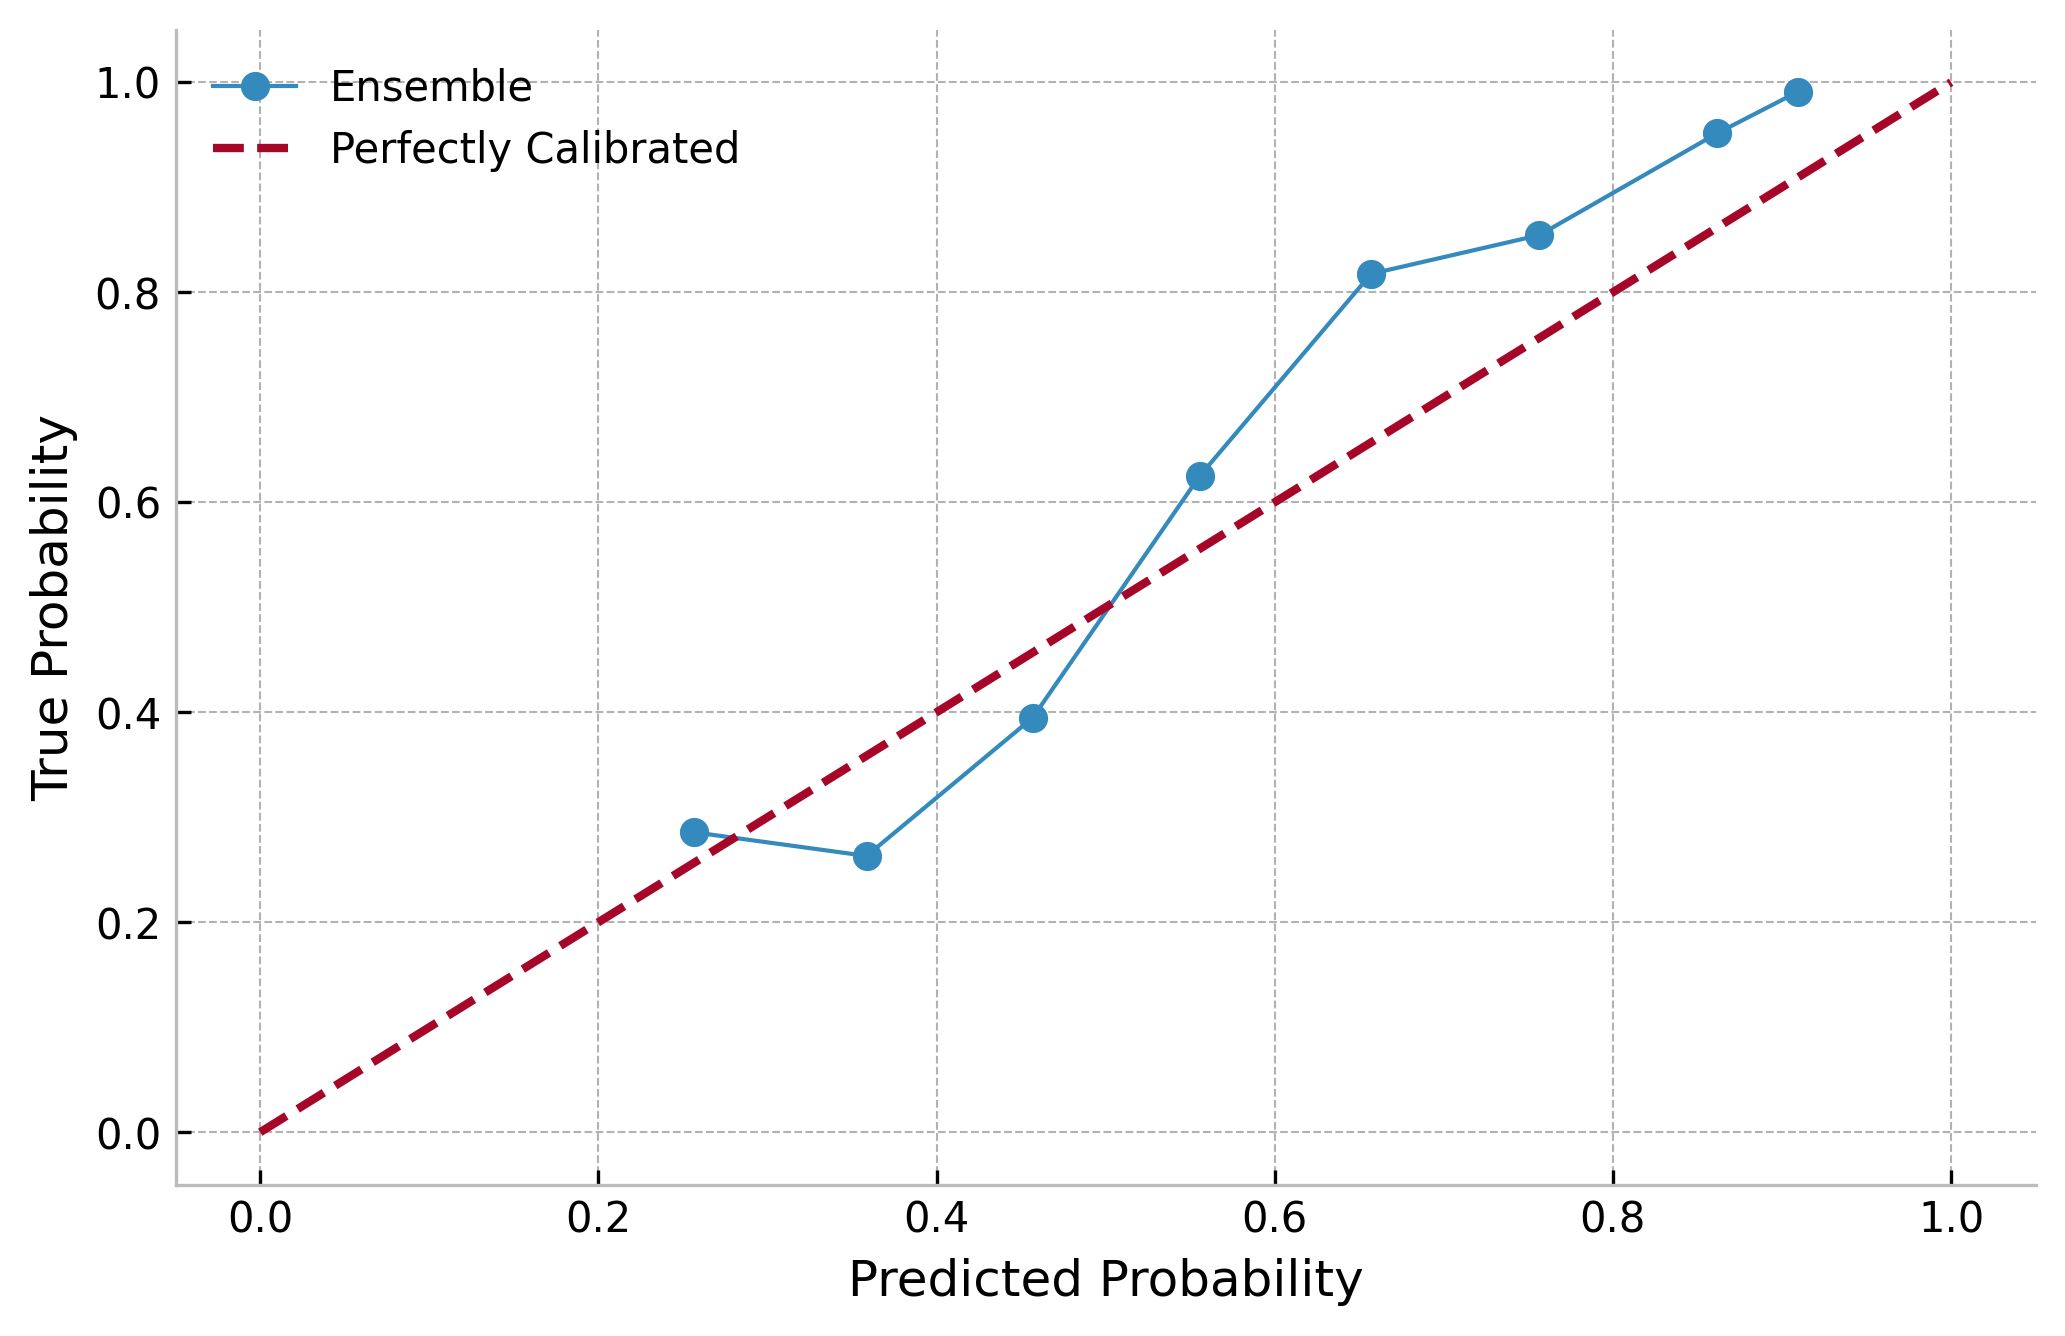

In [6]:
from sklearn.calibration import calibration_curve

true_pos, pred_pos = calibration_curve(y_test, test_prob[:, 1], n_bins=10)
plt.plot(pred_pos,
         true_pos, 
         marker='o', 
         linewidth=1, 
         label='Ensemble')
plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         label='Perfectly Calibrated')

# plt.title('Probability Calibration Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend(loc='best')

plt.savefig(f"{path_images}calibration1.png")
#from PIL import Image
#png2 = Image.open("figures/calibration1.png", mode = "w")
#png2.save("figures/calibration1.tiff")

In [7]:
df_cvd = pd.read_csv("./data/raw/data_cvd.csv", index_col=0, decimal='.')
df_cvd["Follow Up Data"] = pd.to_datetime(df_cvd["Follow Up Data"])
df_cvd["Data prelievo"] = pd.to_datetime(df_cvd["Data prelievo"])
df_cvd["Elapsed"] = (df_cvd["Follow Up Data"] - df_cvd["Data prelievo"]).map(lambda x: x.days // 365)
df_plot = df_test.join(df_cvd["Elapsed"])

assert len(df_plot) == len(df_test)

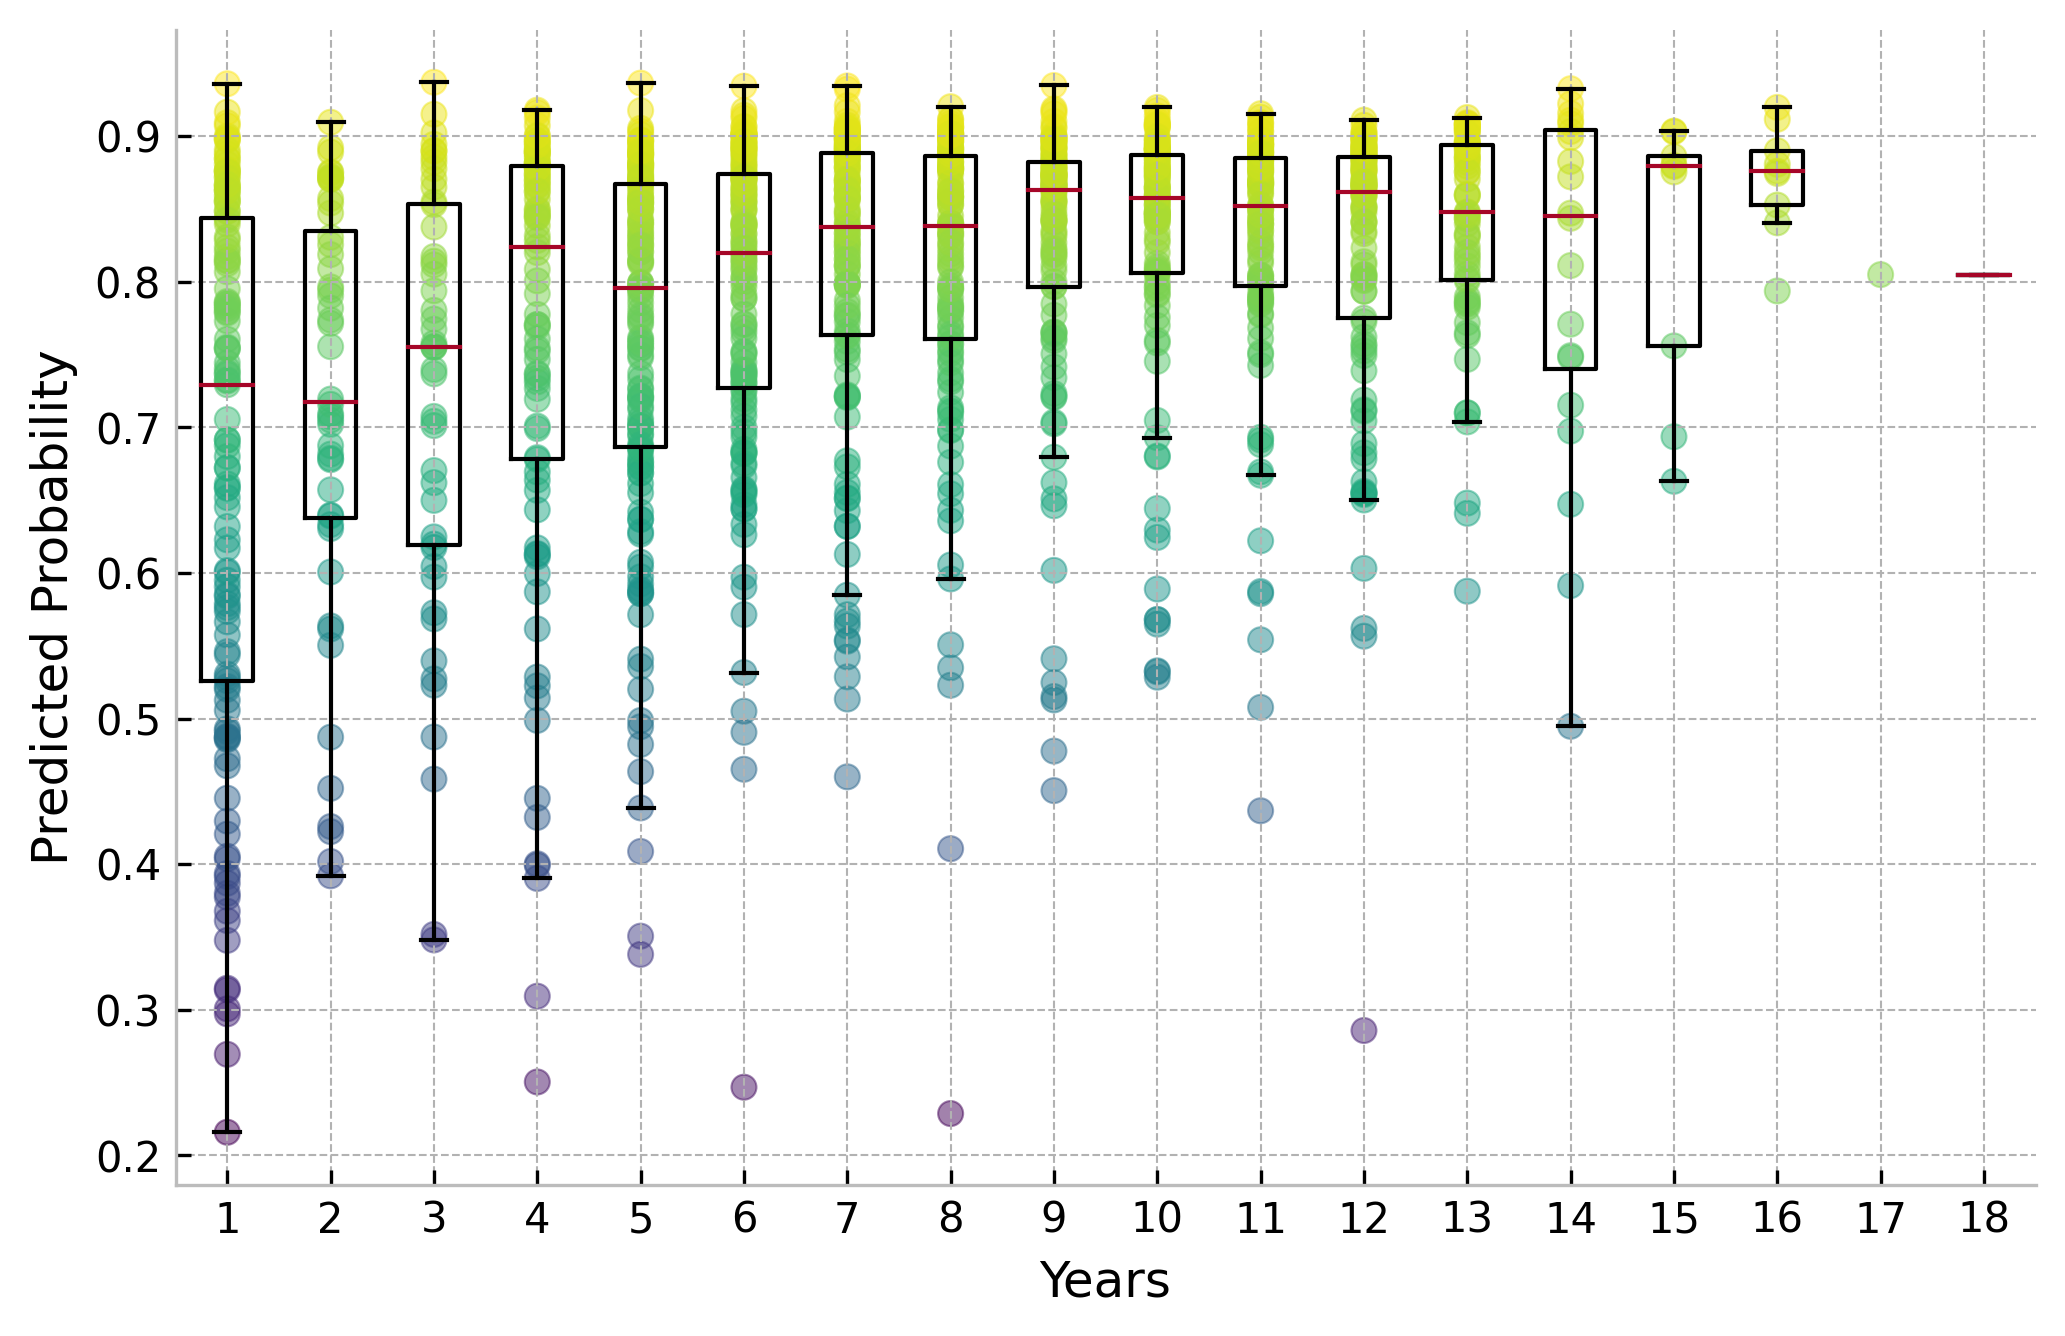

In [8]:
plt.figure(rasterized=True)

boxes = list(map(lambda x: list(x[1].values), list(df_plot.groupby("Elapsed")["ModelOutput"])))
boxes = boxes[:-1] + [[]] + boxes[-1]
plt.boxplot(boxes, showfliers=False)

n = 0.
noise = (np.random.rand(len(df_plot)) * n) - (n / 2)
plt.scatter(df_plot["Elapsed"]+1+noise, df_plot["ModelOutput"], c=df_plot["ModelOutput"], alpha=0.5)

plt.xlabel("Years")
plt.ylabel("Predicted Probability")
# plt.xticks(range(18), [f"n={len(box)}" for box in boxes])
plt.savefig(f"{path_images}calibration.png")
#from PIL import Image
#png2 = Image.open("figures/calibration.png")
#png2.save("figures/calibration.tiff")

### Sampling
Oversample and undersample methods to mitigate data imbalance

In [9]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, OneSidedSelection, NeighbourhoodCleaningRule
from collections import Counter
from train import evaluate
overs = [
    ("smote", SMOTE(sampling_strategy=1.0, k_neighbors=1)),
    ("bordersmote", BorderlineSMOTE(sampling_strategy=1.0, k_neighbors=1)),
    ("svmsmote", SVMSMOTE(sampling_strategy=1.0, k_neighbors=1)), 
    # ADASYN(sampling_strategy=1.0, n_neighbors=1)
]

random_ratio = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
#name_models = ["logreg_top", "rf_top", "adaboost_top"]
name_models = ["lr", "svc", "knn", "rf", "adaboost", "nn", "gb", "xgb"]

for name in name_models:
    best_k = 0
    best_over = ""
    best_score = 0
    best_random = 0
    best_model = None
    best_X, best_y = None, None
    model = load(path_models+f"{name}{suffix}.joblib")

    for r in random_ratio:
        print("-------------------------------------------------")
        print(f"{'Oversample':<20}{'Score':<20}Random {r} Name {name}")
        print("-------------------------------------------------")

        for name_over, over in overs:
            for k in range(2, 5):
                over.set_params(k_neighbors=k)
                under = RandomUnderSampler(sampling_strategy=r)
                # under = OneSidedSelection(n_neighbors=100, n_seeds_S=300)
                # under = NeighbourhoodCleaningRule(n_neighbors=25, threshold_cleaning=0.5)
                X_train_sample, y_train_sample = under.fit_resample(X_train, y_train)
                X_train_sample, y_train_sample = over.fit_resample(X_train_sample, y_train_sample)

                # Evaluate model with 5 runs
                scores = []
                for _ in range(5):
                    model.fit(X_train_sample, y_train_sample)
                    score = f1_score(y_valid, model.predict(X_valid), average="macro")
                    scores.append(score)
                score = np.mean(scores)

                if score > best_score:
                    best_k = k
                    best_over = name_over
                    best_score = score
                    best_random = r
                    best_model = copy.deepcopy(model)
                    best_X = X_train_sample
                    best_y = y_train_sample

            print(f'{name_over:<20}{score:.3f}')

    # Save the dataset and model
    combination = f"{suffix}_random_{best_over}_{name}"
    tmp = np.concatenate((best_X, np.expand_dims(best_y, 1)), axis=1)
    tmp = pd.DataFrame(tmp, columns=feat_names)

    # Current model's statistics
    print("\n")
    print(f"Name model:      \t{name}")
    print(f"Best rand_ratio: \t{best_random}")
    print(f"Best score:      \t{best_score}")
    print(f"Dataset size:    \t{len(best_y)}, {Counter(best_y)}")
    print(f"Combination:     \t{combination}")
    print("\n\n")

    # Evaluate the best model, save the data and the best model
    evaluate(best_model, best_X, best_y)
    evaluate(best_model, X_valid, y_valid)
    tmp.to_csv(path+f"train{combination}.csv")
    dump(best_model, path_models+f"{name}{combination}.joblib")


# save model
tmp.to_csv(path+f"train{combination}.csv")
dump(best_model, path_models+f"{name}{combination}.joblib")

# evaluate the best model
evaluate(best_model, best_X, best_y)
evaluate(best_model, X_valid, y_valid)
tmp.to_csv(path+f"train{combination}.csv")
dump(best_model, path_models+f"{name}{combination}.joblib")

-------------------------------------------------
Oversample          Score               Random 0.2 Name lr
-------------------------------------------------
smote               0.658
bordersmote         0.654
svmsmote            0.664
-------------------------------------------------
Oversample          Score               Random 0.25 Name lr
-------------------------------------------------
smote               0.648
bordersmote         0.642
svmsmote            0.661
-------------------------------------------------
Oversample          Score               Random 0.3 Name lr
-------------------------------------------------
smote               0.650
bordersmote         0.639
svmsmote            0.660
-------------------------------------------------
Oversample          Score               Random 0.35 Name lr
-------------------------------------------------
smote               0.653
bordersmote         0.642
svmsmote            0.660
-------------------------------------------------


['models/18features/xgb_random_svmsmote_xgb.joblib']

### Feature Ablation

In [10]:
from sklearn.inspection import permutation_importance


def get_univariate_ablation_results(X, y):
    """For each feature we set it to its mean value and save the resulting metrics"""

    features = df_valid.columns
    accuracy, auroc, f1_death, f1_survive, f1_macro = [], [], [], [], []
    for i, _ in enumerate(range(X_valid.shape[1])):
        X_copy = X.copy()
        X_copy[:, i] = np.mean(X_copy[:, i]) * np.ones(X_copy.shape[0])
        y_proba, y_pred = predict_ensemble(ensemble, X_copy, y)

        accuracy.append((features[i], round(accuracy_score(y, y_pred), 3)))
        auroc.append((features[i], round(roc_auc_score(y, y_proba[:, 1]), 3)))
        f1_death.append((features[i], round(f1_score(y, y_pred, pos_label=0), 3)))
        f1_survive.append((features[i], round(f1_score(y, y_pred, pos_label=1), 3)))
        f1_macro.append((features[i], round(f1_score(y, y_pred, average="macro"), 3)))
    
    return accuracy, auroc, f1_death, f1_survive, f1_macro


def get_multivariate_ablation_results(feat_clusters, X, y, skip_single=False):
    """For each cluster of features, we set each feature of a group to its mean and save the resulting metrics"""

    accuracy, auroc, f1_death, f1_survive, f1_macro = [], [], [], [], []
    for feat_cluster in feat_clusters:
        if skip_single and (len(feat_cluster)) == 1:
            continue

        # Create a copy of the dataset
        X_copy = X.copy()
        t = []
        for feat in feat_cluster:
            p = feat_names.index(feat)
            t.append(p)
            X_copy[:, p] = np.mean(X_copy[:, p]) * np.ones(X_copy.shape[0])

        # Predict
        y_proba, y_pred = predict_ensemble(ensemble, X_copy, y)
        accuracy.append(round(accuracy_score(y, y_pred), 3))
        auroc.append(round(roc_auc_score(y, y_proba[:, 1]), 3))
        f1_death.append(round(f1_score(y, y_pred, pos_label=0), 3))
        f1_survive.append(round(f1_score(y, y_pred, pos_label=1), 3))
        f1_macro.append(round(f1_score(y, y_pred, average="macro"), 3))
    
    return accuracy, auroc, f1_death, f1_survive, f1_macro

In [11]:
# Univariate ablation
accuracy, auroc, f1_death, f1_survive, f1_macro = get_univariate_ablation_results(X_test, y_test)
p = pd.DataFrame({
    "auroc": [x[1] for x in auroc], 
    "f1_macro": [x[1] for x in f1_macro],
    }, index=feat_names[:-1])
p.to_csv("extra_ablation_uni_test.csv")

In [12]:
# Multivariate hierarchical ablation
with open(f"{path}feat_cluster_hier.df", "rb") as f:
    df_clusters = pickle5.load(f)

accuracy, auroc, f1_death, f1_survive, f1_macro = get_multivariate_ablation_results(df_clusters, X_test, y_test)
p = pd.DataFrame({"cluster": df_clusters, "auroc": auroc, "f1_macro": f1_macro})
p.to_csv("multivariate_ablation_hier_nomeds.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'data/no_thyroid/feat_cluster_hier.df'